# Bloom filter

A conventional hash table (or hash table-backed set structure) consists of a series of _buckets_.  Hash table insert looks like this:

1.  First, use the hash value of the key to identify the index of the bucket that should contain it.  
2.  If the bucket is empty, update the bucket to contain the key and value (with a trivial value in the case of a hashed set).  
3.  If the bucket is not empty and the key stored in it is not the one you've hashed, handle this _hash collision_.  There are several strategies to handle hash collisions precisely; most involve extra lookups (e.g., having a second hash function or going to the next available bucket) or extra space (e.g., having a linked list of keys and values in each bucket).

Hash table lookup proceeds similarly:  

1.  Looking up the index of the bucket that should contain a key (as above).
2.  Check to see if that bucket contains the key.  
  - If the bucket contains the key, return the value (or "true" in the case of a hash-backed set).
  - If the bucket contains nothing, then the key is not in the table.  
  - If the bucket contains something else, follow the strategy for resolving collisions until finding a bucket that contains the key or exhausting all possible buckets.

Think of a [Bloom filter](https://en.wikipedia.org/wiki/Bloom_filter) as a hashed set structure that has no precise way to handle collisions.  Instead, the Bloom filter ameliorates the impact of hash collisions by using _multiple hash functions_.  The buckets in the Bloom filter are merely bits:  they do not have the identities of keys.  When a value is inserted into the Bloom filter, multiple hash functions are used to select which buckets should be set to true (buckets that are already true are not changed).  This means that if _all_ of the buckets for a given key are true, then the Bloom filter _may_ contain it, but that if _any_ of the buckets for a given key are false, then the Bloom filter _must not_ contain it.

Let's see an implementation.  We'll start with a [basic bit vector class](./bit-vector.ipynb) so that we can efficiently store values.

In [1]:
from datasketching.BitVector import BitVector

We can now implement the Bloom filter using the bit vector to store values.

In [2]:
class Bloom(object):
    def __init__(self, size, hashes):
        """ Initializes a Bloom filter with the
            given size and a collection of hashes, 
            which are functions taking arbitrary 
            values and returning integers. 
            
            hashes can be either a function taking 
            a value and returning a list of results
            or a list of functions.  In the latter 
            case, this constructor will synthesize 
            the former """
        self.__buckets = BitVector(size)
        self.__size = len(self.__buckets)
        
        if hasattr(hashes, '__call__'):
            self.__hashes = hashes
        else:
            funs = hashes[:]
            def h(value):
                return [f(value) for f in funs]
            self.__hashes = h
    
    def size(self):
        return self.__size
    
    def insert(self, value):
        """ Inserts a value into this set """
        for h in self.__hashes(value):
            self.__buckets[h % self.__size] = True
    
    def lookup(self, value):
        """ Returns true if value may be in this set
            (i.e., may return false positives) """
        for h in self.__hashes(value):
            if self.__buckets[h % self.__size] == False:
                return False
        return True

Now we'll need some different hash functions to use in our Bloom filter.  [We can simulate multiple hashes](./hashing.ipynb) by using one of the hashes supplied in `hashlib` and simply masking out parts of the digest.

In [3]:
from datasketching.hashing import hashes_for

Now let's construct a Bloom filter using our three hashes.

In [4]:
# Make a Bloom filter with three hashes, 
# each of which is 32 bits (8 hex digits)
bloom = Bloom(1024, hashes_for(3, 8))

In [5]:
bloom.insert("foobar")
bloom.lookup("foobar")

True

In [6]:
bloom.lookup("absent")

False

So far, so good!  Now let's run an experiment to see how our false positive rate changes over time.  We're going to construct a random stream of values and insert them into a Bloom filter -- but we're going to look them up first.  Since it is extremely improbable that we'll get the same random values twice in a short simulation (the period of the Mersenne Twister that Python uses is too large to allow this), we can be fairly certain that any values for which `lookup` returns true before we've inserted them are false positives.  We'll collect the false positive rate at every 100 samples.

In [7]:
def bloom_experiment(sample_count, size, hashes, seed=0x15300625):
    import random
    from collections import namedtuple
   
    random.seed(seed)
    bloom = Bloom(size, hashes)
    
    result = []
    false_positives = 0
    
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if bloom.lookup(bits):
            false_positives = false_positives + 1
        bloom.insert(bits)
        
        if i % 100 == 0:
            result.append((i + 1, false_positives / float(i + 1)))
    result.append((i + 1, false_positives / float(i + 1)))
    return result

Let's set up plotting (using the [Altair API](https://altair-viz.github.io) for the [Vega-Lite](https://vega.github.io) visualization grammar):

In [8]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Then we can run an experiment and plot the results:

In [9]:
from pandas import DataFrame

results = bloom_experiment(1 << 18, 4096, hashes_for(3, 8))
df = DataFrame.from_records(results)
df.rename(columns={0: "unique values", 1: "false positive rate"}, inplace=True)

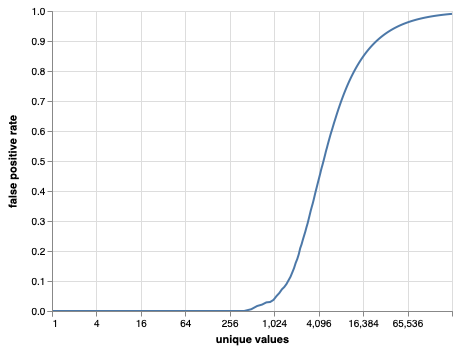

In [10]:
alt.Chart(df).mark_line().encode(alt.X("unique values", scale=alt.Scale(type="log", base=2)), y="false positive rate")

We can see how increasing the size of the filter changes our results:

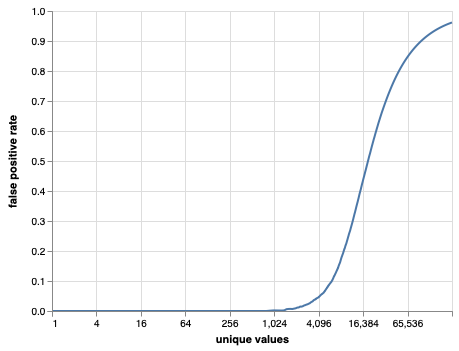

In [11]:
results = bloom_experiment(1 << 18, 16384, hashes_for(3, 8))
df = DataFrame.from_records(results )
df.rename(columns={0: "unique values", 1: "false positive rate"}, inplace=True)

alt.Chart(df).mark_line().encode(alt.X("unique values", scale=alt.Scale(type="log", base=2)), y="false positive rate")

## Analytic properties

We can analytically predict a false positive rate for a given Bloom filter.  If $k$ is the number of hash functions, $m$ is the size of the Bloom filter in bits, and $n$ is the number of elements in the set, we can expect a false positive rate of $ ( 1 - e^{- kn / m} )^k $.  Let's plot that function for our previous example:

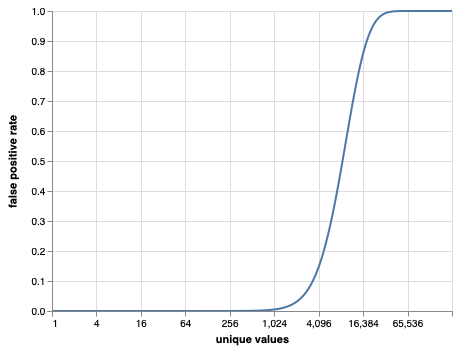

In [12]:
results = []
import math
hash_count = 3
filter_size = 16384

entries = 0
while entries < 1 << 18:
    results.append((entries + 1, math.pow(1 - math.pow(math.e, -((hash_count * (entries + 1)) / filter_size)), hash_count)))
    entries = entries + 100

df = DataFrame.from_records(results)
df.rename(columns={0: "unique values", 1: "false positive rate"}, inplace=True)

alt.Chart(df).mark_line().encode(alt.X("unique values", scale=alt.Scale(type="log", base=2)), y="false positive rate")

As we can see, our expected false positive rate lines up very closely to our actual false positive rate.

## Other useful properties

Since it is possible to incrementally update a Bloom filter by adding a single element, the Bloom filter is suitable for stream processing.

However, it is also possible to find the _union_ of two Bloom filters if they have the same size and were constructed with the same hash functions, which means it is possible to use the Bloom filter for parallel batch processing (i.e., approximating a very large set by combining the Bloom filters approximating its subsets).  The union of Bloom filters approximating sets $A$ and $B$ is the bucketwise OR of $A$ and $B$.  The union of Bloom filters approximating sets $A$ and $B$ will produce the same result as the Bloom filter approximating the set $A \cup B$.

It is also possible to find the _intersection_ of two Bloom filters by taking their bucketwise AND.  $ \mathrm{Bloom}(A) \cap \mathrm{Bloom}(B) $ may be less precise than $ \mathrm{Bloom}(A \cap B) $; the upper bound on the false positive rate for $ \mathrm{Bloom}(A) \cap \mathrm{Bloom}(B) $ will be the greater of the false positive rates for $ \mathrm{Bloom}(A) $ and $ \mathrm{Bloom}(B) $.

In [13]:
class Bloom(object):
    def __init__(self, size, hashes):
        """ Initializes a Bloom filter with the
            given size and a collection of hashes, 
            which are functions taking arbitrary 
            values and returning integers. 
            
            hashes can be either a function taking 
            a value and returning a list of results
            or a list of functions.  In the latter 
            case, this constructor will synthesize 
            the former """
        self.__buckets = BitVector(size)
        self.__size = len(self.__buckets)
        
        if hasattr(hashes, '__call__'):
            self.__hashes = hashes
        else:
            funs = hashes[:]
            def h(value):
                return [int(f(value)) for f in funs]
            self.__hashes = h
    
    def size(self):
        return self.__size
    
    def insert(self, value):
        """ Inserts a value into this set """
        for h in self.__hashes(value):
            self.__buckets[h % self.__size] = True
    
    def lookup(self, value):
        """ Returns true if value may be in this set
            (i.e., may return false positives) """
        for h in self.__hashes(value):
            if self.__buckets[h % self.__size] == False:
                return False
        return True
    
    def merge_from(self, other):
        """ Merges other in to this filter by 
            taking the bitwise OR of this and 
            other.  Updates this filter in place. """
        self.__buckets.merge_from(other.__buckets)
    
    def intersect(self, other):
        """ Takes the approximate intersection of 
            this and other, returning a new filter 
            approximating the membership of the 
            intersection of the set approximated 
            by self and the set approximated by other.
            
            The upper bound on the false positive rate 
            of the resulting filter is the greater of 
            the false positive rates of self and other 
            (but the FPR may be worse than the FPR of 
            a Bloom filter constructed only from the 
            values in the intersection of the sets 
            approximated by self and other). """
        
        b = Bloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.intersect_from(other.__buckets)
        return b
    
    def union(self, other):
        """ Generates a Bloom filter approximating the 
            membership of the union of the set approximated
            by self and the set approximated by other.
            
            Unlike intersect, this does not affect the 
            precision of the filter (i.e., its precision
            will be identical to that of a Bloom filter 
            built up from the union of the two sets). """
        
        b = Bloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.merge_from(other.__buckets)
        return b
        
    
    def dup(self):
        b = Bloom(self.size(), self.__hashes)
        b.merge_from(self)
        return b

We can see these in action:

In [14]:
b1 = Bloom(1024, hashes_for(3, 8))
b2 = Bloom(1024, hashes_for(3, 8))

b1.insert("foo")
b1.insert("bar")
b2.insert("foo")
b2.insert("blah")

b_intersect = b1.intersect(b2)
b_intersect.lookup("foo")

True

In [15]:
b_intersect.lookup("blah")

False

In [16]:
b_union = b1.union(b2) 
b_union.lookup("blah"), b_union.lookup("bar")

(True, True)

## Partitioned Bloom Filters

The _partitioned Bloom filter_ simply divides the set of buckets into several partitions (one for each hash function) so that, e.g., a bit in partition 0 can only be set by hash 0, and so on.  A major advantage of the partitioned Bloom filter is that it has a better false positive rate under intersection (see the reference to Jeffrey and Steffan below), which can be better used to identify potential conflicts between very large sets.

Because we track the count of hash functions explicitly (in the count of partitions), we can also easily adapt the cardinality estimation technique of [Swamidass and Baldi](http://www.igb.uci.edu/~pfbaldi/publications/journals/2007/ci600526a.pdf).

In [17]:
class PartitionedBloom(object):
    def __init__(self, size, hashes):
        """ Initializes a Bloom filter with the
            given per-partition size and a collection 
            of hashes, which are functions taking 
            arbitrary values and returning integers.  
            The partition count is the number of hashes.
            
            hashes can be either a function taking 
            a value and returning a list of results
            or a list of functions.  In the latter 
            case, this constructor will synthesize 
            the former """
        if hasattr(hashes, '__call__'):
            self.__hashes = hashes
            # inspect the tuple returned by the hash function to get a depth
            self.__depth = len(hashes(bytes()))
        else:
            funs = hashes[:]
            self.__depth = len(hashes)
            def h(value):
                return [int(f(value)) for f in funs]
            self.__hashes = h
        
        self.__buckets = BitVector(size * self.__depth)
        self.__size = size

    
    def size(self):
        return self.__size
    
    def partitions(self):
        return self.__depth
    
    def insert(self, value):
        """ Inserts a value into this set """
        for (p, row) in enumerate(self.__hashes(value)):
            self.__buckets[(p * self.__size) + (row % self.__size)] = True
    
    def lookup(self, value):
        """ Returns true if value may be in this set
            (i.e., may return false positives) """
        for (p, row) in enumerate(self.__hashes(value)):
            if not self.__buckets[(p * self.__size) + (row % self.__size)]:
                return False
        return True
    
    def merge_from(self, other):
        """ Merges other in to this filter by 
            taking the bitwise OR of this and 
            other.  Updates this filter in place. """
        self.__buckets.merge_from(other.__buckets)
    
    def intersect(self, other):
        """ Takes the approximate intersection of 
            this and other, returning a new filter 
            approximating the membership of the 
            intersection of the set approximated 
            by self and the set approximated by other.
            
            The upper bound on the false positive rate 
            of the resulting filter is the greater of 
            the false positive rates of self and other 
            (but the FPR may be worse than the FPR of 
            a Bloom filter constructed only from the 
            values in the intersection of the sets 
            approximated by self and other). """
        
        b = PartitionedBloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.intersect_from(other.__buckets)
        return b
    
    def union(self, other):
        """ Generates a Bloom filter approximating the 
            membership of the union of the set approximated
            by self and the set approximated by other.
            
            Unlike intersect, this does not affect the 
            precision of the filter (i.e., its precision
            will be identical to that of a Bloom filter 
            built up from the union of the two sets). """
        
        b = PartitionedBloom(self.size(), self.__hashes)
        b.__buckets.merge_from(self.__buckets)
        b.__buckets.merge_from(other.__buckets)
        return b
        
    
    def dup(self):
        b = PartitionedBloom(self.size(), self.__hashes)
        b.merge_from(self)
        return b
    
    def approx_cardinality(self):
        """ Returns an estimate of the cardinality of
            the set modeled by this filter.  Uses
            a technique due to Swamidass and Baldi. """
        from math import log
        m, k = self.size() * self.partitions(), self.partitions()
        X = self.__buckets.count_set_bits()
        print(m, k, X)
        return -(m / k) * log(1 - (X / m))


In [18]:
def pbloom_experiment(sample_count, size, hashes, mod1=3, mod2=7, seed=0x15300625):
    import random
    from collections import namedtuple
   
    random.seed(seed)
    pb1 = PartitionedBloom(size, hashes)
    pb2 = PartitionedBloom(size, hashes)
    
    b1 = Bloom(pb1.size() * pb1.partitions(), hashes)
    b2 = Bloom(pb1.size() * pb1.partitions(), hashes)
    result = []
    pb_fp, b_fp = 0, 0
    
    count = 0
    
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if i % mod1 == 0:
            pb1.insert(bits)
            b1.insert(bits)
        if i % mod2 == 0:
            pb2.insert(bits)
            b2.insert(bits)
            if i % mod1 == 0:
                count += 1
    
    pb = pb1.intersect(pb2)
    b = b1.intersect(b2)
    
    random.seed(seed)
    
    for i in range(sample_count):
        bits = random.getrandbits(64)
        if pb.lookup(bits) and ((i % mod1 != 0) or (i % mod2 != 0)):
            pb_fp += 1
        if b.lookup(bits) and ((i % mod1 != 0) or (i % mod2 != 0)):
            b_fp += 1
    return (count, b_fp, pb_fp)

In [19]:
results = []

for pwr in range(10, 17):
    for count in [1 << pwr, (1 << pwr) + (1 << (pwr - 1))]:
        tp, bfp, pbfp = pbloom_experiment(count, 16384, hashes_for(8, 4))
        results.append(("Bloom", count, bfp / (float(tp) + bfp)))
        results.append(("partitioned Bloom", count, pbfp / (float(tp) + pbfp)))
    
df = DataFrame.from_records(results )
df.rename(columns={0: "kind", 1: "unique values", 2: "FPR"}, inplace=True)

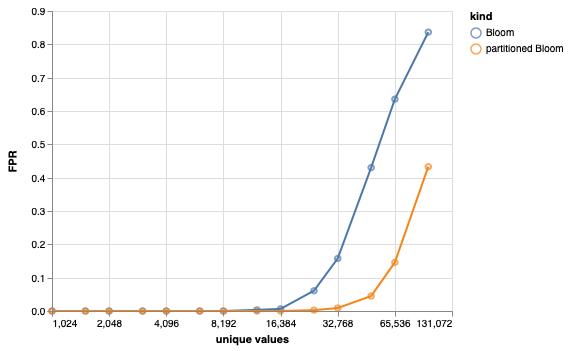

In [20]:
import altair as alt

alt.renderers.enable('notebook')
base = alt.Chart(df).encode(alt.X("unique values", scale=alt.Scale(type="log", base=2)), y="FPR", color="kind")
base.mark_point() + base.mark_line()

## Applications

* The application Bloom used as a case study in [his paper introducing the structure](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.20.2080) was a hyphenation program, in which roughly 90% of words could be hyphenated by simple rules but 10% required a dictionary lookup -- and the dictionary was too large to hold in core.  By using a small Bloom filter to record the words that required dictionary lookup, it would be possible possible to dramatically reduce disk accesses without impacting the correctness of the application.
* [Bloom join](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.134.5196) is a classic technique to optimize joins in distributed databases.  The result of a join is, logically, the subset of the Cartesian product of two relations that satisfies some predicate (typically an equality relation on a field).  There are many strategies for implementing joins in conventional databases, but these may prove prohibitive in a distributed database, where different relations may reside on different machines.  Bloom join optimizes these joins by allowing local filtering of the relations involved.  For example, consider the SQL statement `SELECT * FROM A, B WHERE A.x = B.x`:  by broadcasting Bloom filters of the sets of values for `x` in both `A` and `B`, it is possible to filter out many tuples that would never appe
* Bloom filters are often implemented in hardware, since a range of microarchitectural features can benefit from fast approximate set membership queries.  For one example application, see [Jeffrey and Steffan](http://www.eecg.toronto.edu/~steffan/papers/jeffrey_spaa11.pdf), in which the motivating example involves using Bloom filters to show that two hardware transactions do not interfere before allowing them to commit.  (This technique is not their innovation; rather, the focus of Jeffrey and Steffan's work is to show that _partitioned Bloom filters_ admit a smaller false positive rate for the intersection of Bloom filters, and thus set disjointedness.)